In [87]:
from pathlib import Path
root_path = Path.cwd().parent.absolute()
import sys
sys.path.append(str(root_path))

In [88]:
import torch as torch
from torch.distributions import MultivariateNormal
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import numpy as np 
import matplotlib.pyplot as plt

import parametric_pushforward.data_sets as toy_data
from parametric_pushforward.parametric_mlp import order_state_to_tensor
from parametric_pushforward.visualization import disimilarity_snapshots,disimilarity_plot
from parametric_pushforward.spline import Assemble_spline
from parametric_pushforward.obstacles import obstacle_cost_stunnel, obstacle_cost_vneck, obstacle_cost_gmm,congestion_cost,geodesic
from parametric_pushforward.opinion import PolarizeDyn,proj_pca
from parametric_pushforward.setup_density_path_problem import load_boundary_models,get_activation,opinion_dynamics_setup,get_potential_functions

from geomloss import SamplesLoss

sinkhorn = SamplesLoss(loss = 'sinkhorn', p = 2, blur = 0.05)

from opinion import PolarizeDyn,est_directional_similarity

import os
import yaml


In [89]:
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)

In [90]:
# name of experiment
exp_dir = str(root_path)+  '/experiments/gauss0_opinion_1000d_to_gauss1_opinion_1000d_pot_congestion_cost_20250416_125836'
yaml_path = os.path.join(exp_dir, 'config.yaml')
with open(yaml_path) as file:
    config = yaml.load(file, Loader=yaml.FullLoader)


In [91]:

name_data0 = config['data']['source']['name']
checkpt0 = 'final'#'checkpoint_1999'
name_data1 = config['data']['target']['name']
checkpt1 = 'final'#'checkpoint_1999'

arch_dims = [config['architecture']['input_dim'],config['architecture']['hidden_dim'],config['architecture']['num_layers']]
activation = get_activation(config['architecture']['activation'])

arch = arch_dims+[activation]

spline_type = config['spline']['type']


prior = MultivariateNormal(torch.zeros(config['architecture']['input_dim']).to(device),torch.eye(config['architecture']['input_dim']).to(device))

state0,state1 = load_boundary_models(config,device)
theta0 = order_state_to_tensor(state0)
theta1 = order_state_to_tensor(state1)

if config.get('opinion_dynamics',{}).get('active',False):
    print('Opinion dynamics active')
    opinion_dynamics = opinion_dynamics_setup(config)
    ke_modifier = [PolarizeDyn(opinion_dynamics).to(device)]
else:
    ke_modifier = None


Opinion dynamics active
USING BM XI! xis.sum(): 203.8768310546875


In [92]:
# Build spline
num_collocation = config['spline']['num_collocation']
spline0,t = Assemble_spline(theta0=theta0,
                            theta1=theta1,
                            arch=arch,
                            data0=name_data0,
                            data1=name_data1,
                            ke_modifier=ke_modifier,
                            potential=get_potential_functions(config['potential_functions']),
                            number_of_knots=num_collocation,
                            spline=spline_type,
                            device = device,
                            prior_dist=prior)

spline0.sigma = config['coefficients_potentials']['sigma']


In [93]:

spline_path = os.path.join(exp_dir, 'checkpoints/spline.pth')
try:
    state_spline0 = torch.load(spline_path,map_location=device)#['ema_model']
    spline0.load_state_dict(state_spline0)
except:
    state_spline0 = torch.load(spline_path,map_location=device)['ema_model']
    spline0.load_state_dict(state_spline0)

spline0.eval()
spline0.sigma

0

In [94]:
samples = 5000
t_node = 10
x0 = torch.from_numpy(toy_data.inf_train_gen(name_data0, batch_size=samples,dim = config['architecture']['input_dim'])).float().to(device)
# x1 = torch.from_numpy(toy_data.inf_train_gen(name_data1, batch_size=samples,dim = config['architecture']['input_dim'])).float().to(device)
# # Get z values by flowing backwards
z0 = spline0.pull_back(spline0.x0.flatten(),x0)
# y0 = spline0.push_forward(spline0.x1.flatten(),z0)


# z0 = spline0.prior_dist.sample((samples,)).to(device)
# z1 = z0.clone()

/work/Sebas/miniconda3/envs/PDPO/lib/python3.12/site-packages/torchdyn/numerics/odeint.py:83: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


In [95]:
plt.scatter(z0[:,0].cpu().detach().numpy(),z0[:,1].cpu().detach().numpy(),s=1)
#Samples from the prior
prior_samples = prior.sample((samples,)).to(device)
plt.scatter(prior_samples[:,0].cpu().detach().numpy(),prior_samples[:,1].cpu().detach().numpy(),s=1)
plt.title('Samples from the prior and pullback')
plt.xlabel('x0')
plt.ylabel('x1')
plt.savefig(os.path.join(exp_dir,'figures/pullback_samples.png'),dpi=300)
plt.close()

In [96]:
# Path plot

s = torch.linspace(0,1,5).to(device)

In [97]:
# interpolation0 = spline0(s)
# samples_path0 = path_visualization_snapshots(interpolation=interpolation0,arch = arch,
# spline = spline0,
# x0 = config['visualization']['plot_bounds']['x_min'],
# y0 = config['visualization']['plot_bounds']['y_min'],
# x1 = config['visualization']['plot_bounds']['x_max'],
# y1 = config['visualization']['plot_bounds']['y_max'],
# num_samples = 50,
# time_steps = 10,solver = 'midpoint',
# z = z0,num_contour_points = 250)

In [98]:
samples_path = spline0.gen_sample_trajectory(z0,num_samples=len(z0),t_traj=s,time_steps_node=10,solver='midpoint')

In [99]:
samples = 10_000

In [100]:

z0 = spline0.prior_dist.sample((samples,)).to(device)
terminal_dist = spline0.push_forward(spline0.x1.flatten(),z0)
x1 = torch.from_numpy(toy_data.inf_train_gen(name_data1, batch_size=samples,dim = config['architecture']['input_dim'])).float().to(device)

In [101]:
x1_reshape = x1.unsqueeze(0).permute(1,0,2)
terminal_dist_reshape = terminal_dist.unsqueeze(0).permute(1,0,2)


In [102]:
# Load samples from gsbm

import pickle

gsbm_dir = str(root_path)+ '/results_gsbm/opinion_1000d/'

with open(os.path.join(gsbm_dir+'xs.pickle'),'rb') as f:
    gsbm_sol = pickle.load(f)

In [103]:
xs_gsbm = gsbm_sol['xs']

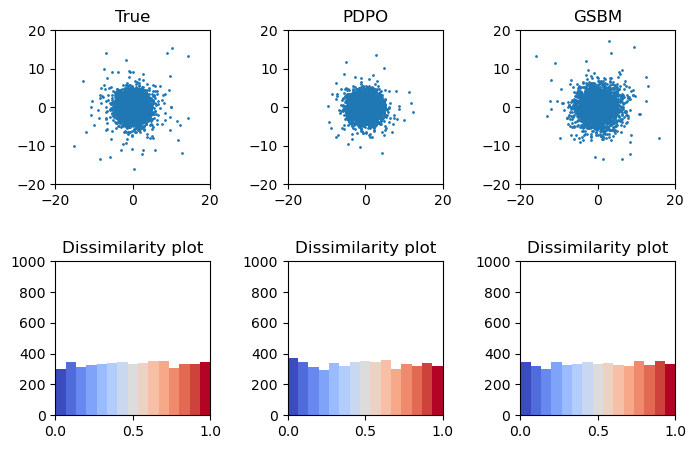

In [113]:
fig, ax = plt.subplots(2, 3, figsize=(8, 5))
ax = ax.flatten()

# Add this line to increase space between rows
plt.subplots_adjust(hspace=0.5,wspace=0.5)  # Increase this value to add more space

lim_plot_low = -20
lim_plot_high = 20
terminal_dist_pca = proj_pca(terminal_dist_reshape)[0]
x1_pca = proj_pca(x1_reshape)[0]
xs_gsbm_pca = proj_pca(xs_gsbm)[0]
ax[0].scatter(x1_pca[:,0,0].cpu().detach().numpy(), x1_pca[:,0,1].cpu().detach().numpy(), s=1)
ax[0].set_title('True')
ax[0].set_xlim(lim_plot_low, lim_plot_high)
ax[0].set_ylim(lim_plot_low, lim_plot_high)
ax[1].scatter(terminal_dist_pca[:,0,0].cpu().detach().numpy(), terminal_dist_pca[:,0,1].cpu().detach().numpy(), s=1)
ax[1].set_title('PDPO')
ax[1].set_xlim(lim_plot_low, lim_plot_high)
ax[1].set_ylim(lim_plot_low, lim_plot_high)
ax[2].scatter(xs_gsbm_pca[:,-1,0].cpu().detach().numpy(), xs_gsbm_pca[:,-1,1].cpu().detach().numpy(), s=1)
ax[2].set_title('GSBM')
ax[2].set_xlim(lim_plot_low, lim_plot_high)
ax[2].set_ylim(lim_plot_low, lim_plot_high)
disimilarity_plot(x1_pca[:,0,:], ax[3])
ax[3].set_title('Dissimilarity plot')
disimilarity_plot(terminal_dist_pca[:,0,:], ax[4])
ax[4].set_title('Dissimilarity plot')
disimilarity_plot(xs_gsbm_pca[:,-1,:], ax[5])
ax[5].set_title('Dissimilarity plot')
plt.show()

In [109]:
# animation = create_particle_animation(spline0,samples_path0.detach().cpu().permute(1,0,2),interval=250)
# display(animation)

/work/Sebas/Density_Path_Opt/Parametric_pushforward/parametric_pushforward/visualization.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


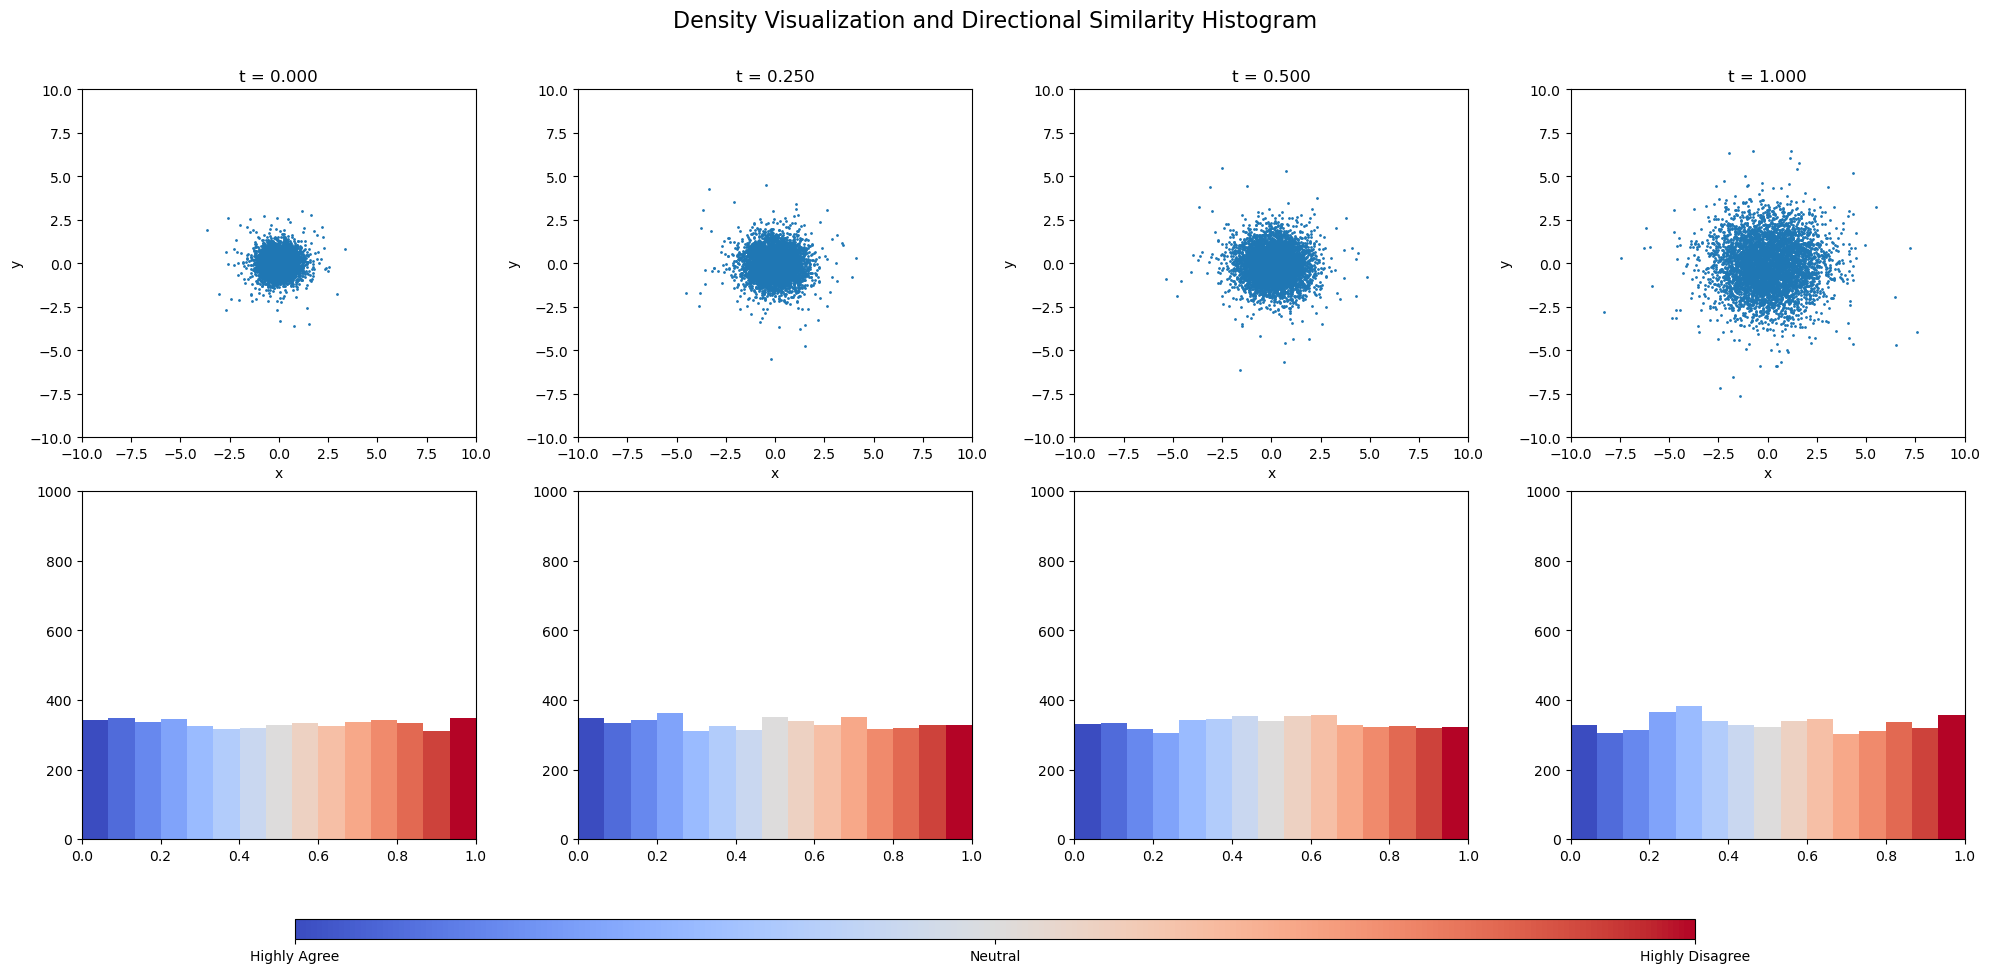

In [110]:
disimilarity_snapshots(samples_path)

/work/Sebas/Density_Path_Opt/Parametric_pushforward/parametric_pushforward/visualization.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


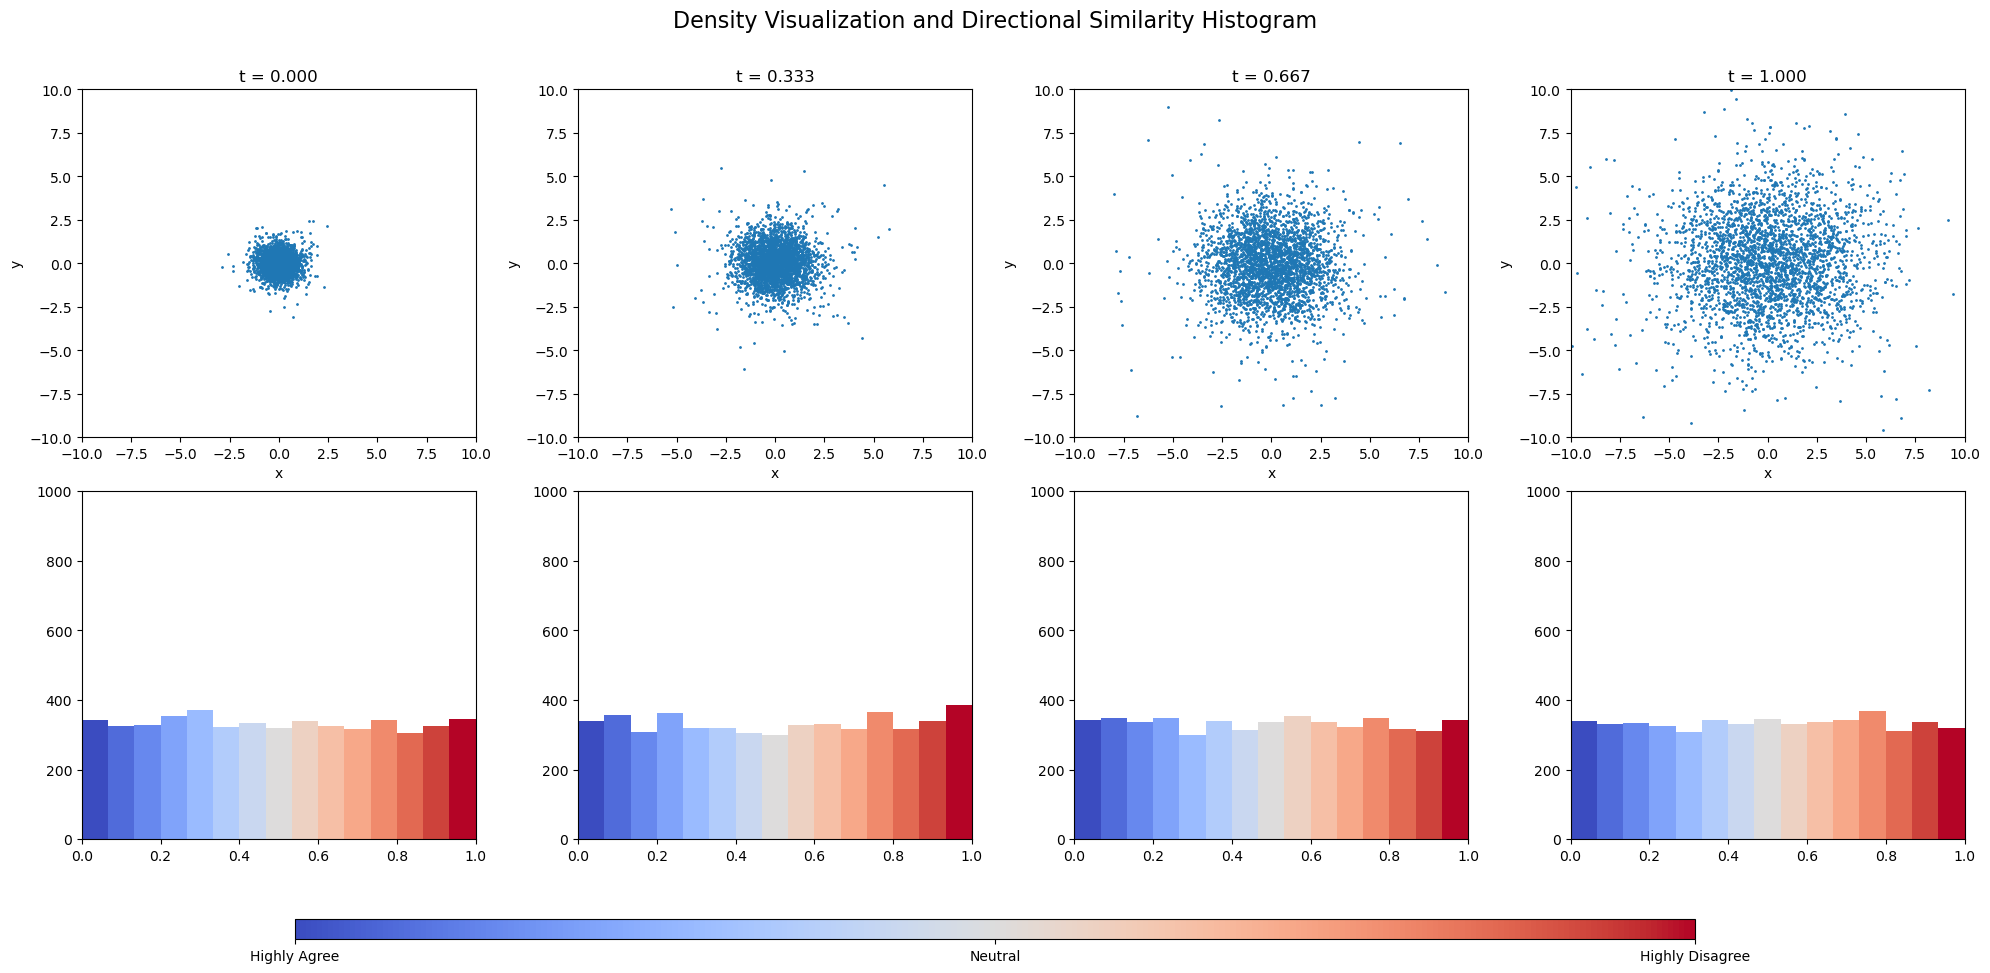

In [111]:
disimilarity_snapshots(xs_gsbm)